Bây giờ bạn đã hiểu được điểm mấu chốt đằng sau thuật toán hồi quy tuyến tính, chúng ta đã có thể bắt đầu thực hành viết mã. Trong phần này, ta sẽ xây dựng lại toàn bộ kĩ thuật này từ đầu, bao gồm: pipeline dữ liệu, mô hình, hàm mất mát và phương pháp tối ưu hạ gradient. Vì các framework học sâu hiện đại có thể tự động hóa gần như tất cả các công đoạn ở trên, việc lập trình mọi thứ từ đầu chỉ để đảm bảo bạn biết rõ mình đang làm gì. Hơn nữa, việc hiểu rõ cách mọi thứ hoạt động sẽ giúp ta rất nhiều trong những lúc cần tùy chỉnh các mô hình, tự định nghĩa lại các tầng tính toán hay các hàm mất mát, v.v. Trong phần này, chúng ta chỉ dựa vào ndarray và autograd. Sau đó, chúng tôi sẽ giới thiệu một phương pháp triển khai chặt chẽ hơn, tận dụng các tính năng tuyệt vời của Gluon. Để bắt đầu, chúng ta cần khai báo một vài gói thư viện cần thiết.

In [ ]:
!pip install d2l==1.0.0-beta0

In [ ]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l
import random

In [ ]:
# %matplotlib inline
# from d2l import mxnet as d2l
# from mxnet import autograd, np, npx
# import random
# npx.set_np()

# 3.2.1. Tạo tập dữ liệu

Để giữ cho mọi thứ đơn giản, chúng ta sẽ xây dựng một tập dữ liệu nhân tạo theo một mô hình tuyến tính với nhiễu cộng. Nhiệm vụ của chúng ta là khôi phục các tham số của mô hình này bằng cách sử dụng một tập hợp hữu hạn các mẫu có trong tập dữ liệu đó. Chúng ta sẽ sử dụng dữ liệu ít chiều để thuận tiện cho việc minh họa. Trong đoạn mã sau, chúng ta đã tạo một tập dữ liệu chứa  $1000$  mẫu, mỗi mẫu bao gồm  $2$  đặc trưng được lấy ngẫu nhiên theo phân phối chuẩn. Do đó, tập dữ liệu tổng hợp của chúng ta sẽ là một đối tượng  $X∈R^{1000×2}$.

Các tham số đúng để tạo tập dữ liệu sẽ là  $w=[2,−3.4]^⊤$  và  b=4.2  và nhãn sẽ được tạo ra dựa theo mô hình tuyến tính với nhiễu  $ϵ$ :
$$y=Xw+b+ϵ$$.

Bạn đọc có thể xem  ϵ  như là sai số tiềm ẩn của phép đo trên các đặc trưng và các nhãn. Chúng ta sẽ mặc định các giả định tiêu chuẩn đều thỏa mãn và vì thế  $ϵ$  tuân theo phân phối chuẩn với trung bình bằng  0 . Để đơn giản, ta sẽ thiết lập độ lệch chuẩn của nó bằng  $0.01$. Đoạn mã nguồn sau sẽ tạo ra tập dữ liệu tổng hợp:

In [ ]:
def synthetic_data(w, b, num_examples):
  X = torch.randn(num_examples, len(w))
  print(X.size())
  y = X@w + b
  print("1. ", y.size())
  y += torch.empty(y.size()).normal_(mean = 0, std = 0.01) # Add noise
  print("2. ", y.size())
  return X,y

true_w = torch.tensor([2, - 3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])
# Saved in the d2l package for later use
# def synthetic_data(w, b, num_examples):
#     """Generate y = X w + b + noise."""
#     X = np.random.normal(0, 1, (num_examples, len(w)))
#     print(X.shape)
#     y = np.dot(X, w) + b
#     print("1. ", y.shape)
#     y += np.random.normal(0, 0.01, y.shape)
#     print("2. ", y.shape)
#     return X, y

# true_w = np.array([2, -3.4])
# true_b = 4.2
# features, labels = synthetic_data(true_w, true_b, 1000)
# print('features:', features[0],'\nlabel:', labels[0])

torch.Size([1000, 2])
1.  torch.Size([1000])
2.  torch.Size([1000])
features: tensor([ 0.5708, -1.5961]) 
label: tensor(10.7754)


Bằng cách vẽ đồ thị phân tán với chiều thứ hai features[:, 1] và labels, ta có thể quan sát rõ mối tương quan tuyến tính giữa chúng.

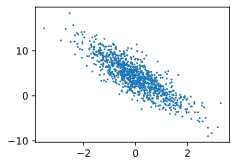

In [ ]:
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

# 3.2.2. Đọc từ Tập dữ liệu

Nhắc lại rằng việc huấn luyện mô hình bao gồm tách tập dữ liệu thành nhiều phần (các mininbatch), lần lượt đọc từng phần của tập dữ liệu mẫu, và sử dụng chúng để cập nhật mô hình của chúng ta. Vì quá trình này rất căn bản để huấn luyện các giải thuật học máy, ta nên định nghĩa một hàm để trộn và truy xuất dữ liệu trong các minibatch một cách tiện lợi.

Ở đoạn mã dưới đây, chúng ta định nghĩa hàm data_iter để minh hoạ cho một cách lập trình chức năng này. Hàm này lấy kích thước một batch, một ma trận đặc trưng và một vector các nhãn rồi sinh ra các minibatch có kích thước batch_size. Mỗi minibatch gồm một tuple các đặc trưng và nhãn.

In [ ]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i + batch_size, num_examples)]
    )
    yield features[batch_indices], labels[batch_indices]

Lưu ý rằng thông thường chúng ta muốn dùng các minibatch có kích thước phù hợp để tận dụng tài nguyên phần cứng GPU để xử lý song song hiệu quả nhất. Vì mỗi mẫu có thể được mô hình xử lý và tính đạo hàm riêng của hàm mất mát song song với nhau, GPU cho phép xử lý hàng trăm mẫu cùng lúc mà chỉ tốn thời gian hơn một chút so với xử lý một mẫu duy nhất.

Để hiểu hơn, chúng ta hãy chạy đoạn chương trình để đọc và in ra batch đầu tiên của mẫu dữ liệu. Kích thước của các đặc trưng trong mỗi minibatch cho ta biết kích thước của batch lẫn số lượng của các đặc trưng đầu vào. Tương tự, tập minibatch của các nhãn sẽ có kích thước theo batch_size.

In [ ]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, "\n", y)
  break

tensor([[ 1.4276, -1.2707],
        [-0.3536, -0.4289],
        [-0.3482,  0.7243],
        [ 0.5620, -0.4608],
        [ 0.2531, -0.1577],
        [ 0.9871,  0.5455],
        [-0.9704,  1.4744],
        [-0.6342, -0.1023],
        [ 0.4815,  2.0509],
        [ 1.4779,  2.5625]]) 
 tensor([11.3836,  4.9505,  1.0623,  6.8918,  5.2326,  4.3313, -2.7615,  3.3066,
        -1.8081, -1.5525])


# 3.2.3. Khởi tạo các Tham số Mô hình

Để tối ưu các tham số của dữ liệu bằng hạ gradient, đầu tiên ta cần khởi tạo chúng. Trong đoạn mã dưới đây, ta khởi tạo các trọng số bằng cách lấy ngẫu nhiên các mẫu từ một phân phối chuẩn với giá trị trung bình bằng $0$ và độ lệch chuẩn là  $0.01$ , sau đó gán hệ số điều chỉnh  $b$  bằng  $0$ .

In [ ]:
w = torch.empty(2,1).normal_(mean = 0, std = 0.01)
b = torch.zeros(1)
# w.requires_grad_(True), b.requires_grad_(True)
w, b

(tensor([[ 0.0179],
         [-0.0075]]), tensor([0.]))

# 3.2.4. Định nghĩa Mô hình

Tiếp theo, chúng ta cần định nghĩa mô hình dựa trên đầu vào và tham số liên quan tới đầu ra. Nhắc lại rằng để tính đầu ra của một mô hình tuyến tính, ta có thể đơn giản tính tích vô hướng ma trận-vector của các mẫu  X  và trọng số mô hình  w , sau đó thêm vào hệ số điều chỉnh  b  cho từng mẫu. Ở đây, np.dot(X, w) là một vector trong khi b là một số vô hướng. Nhắc lại rằng khi tính tổng vector và số vô hướng, thì số vô hướng sẽ được cộng vào từng phần tử của vector.

In [ ]:
def linreg (X, w, b):
  return X@w + b

# 3.2.5. Định nghĩa Hàm Mất mát

Để cập nhật mô hình ta phải tính gradient của hàm mất mát, vậy nên ta cần định nghĩa hàm mất mát trước tiên. Chúng ta sẽ sử dụng hàm mất mát bình phương (SE) như đã trình bày ở phần trước đó. Trên thực tế, chúng ta cần chuyển đổi giá trị nhãn thật y sang kích thước của giá trị dự đoán y_hat. Hàm dưới đây sẽ trả về kết quả có kích thước tương đương với kích thước của y_hat.

In [ ]:
def squared_loss (y_hat, y):
  return (y_hat - y.reshape(y_hat.size()))**2 / 2

# 3.2.6. Định nghĩa thuật toán tối ưu

Như đã thảo luận ở mục trước, hồi quy tuyến tính có một nghiệm dạng đóng. Tuy nhiên, đây không phải là một cuốn sách về hồi quy tuyến tính, mà là về Học sâu. Vì không một mô hình nào khác được trình bày trong cuốn sách này có thể giải được bằng phương pháp phân tích, chúng tôi sẽ nhân cơ hội này để giới thiệu với các bạn ví dụ đầu tiên về hạ gradient ngẫu nhiên (stochastic gradient descent – SGD).

Sử dụng một batch được lấy ngẫu nhiên từ tập dữ liệu tại mỗi bước, chúng ta sẽ ước tính được gradient của mất mát theo các tham số. Tiếp đó, ta sẽ cập nhật các tham số (với một lượng nhỏ) theo chiều hướng làm giảm sự mất mát. Nhớ lại từ Section 2.5 rằng sau khi chúng ta gọi backward, mỗi tham số (param) sẽ có gradient của nó lưu ở param.grad. Đoạn mã sau áp dụng cho việc cập nhật SGD, đưa ra một bộ các tham số, tốc độ học và kích thước batch. Kích thước của bước cập nhật được xác định bởi tốc độ học lr. Bởi vì các mất mát được tính dựa trên tổng các mẫu của batch, ta chuẩn hóa kích thước bước cập nhật theo kích thước batch (batch_size), sao cho độ lớn của một bước cập nhật thông thường không phụ thuộc nhiều vào kích thước batch.

In [ ]:
def sgd(params, lr, batch_size):
  for param in params:
    #print(param.grad)
    with torch.no_grad():
      param[:] = param - lr * param.grad / batch_size

# 3.2.7. Huấn Luyện
Bây giờ, sau khi đã có tất cả các thành phần, chúng ta đã sẵn sàng để viết vòng lặp huấn luyện. Quan trọng nhất là bạn phải hiểu được rõ đoạn mã này bởi vì việc huấn luyện gần như tương tự thế này sẽ được lặp lại nhiều lần trong suốt qua trình chúng ta tìm hiểu và lập trình các thuật toán học sâu.

Trong mỗi vòng lặp, đầu tiên chúng ta sẽ lấy ra các minibatch dữ liệu và chạy nó qua mô hình để lấy ra tập kết quả dự đoán. Sau khi tính toán sự mất mát, chúng ta dùng hàm backward để bắt đầu lan truyền ngược qua mạng lưới, lưu trữ các gradient tương ứng với mỗi tham số trong từng thuộc tính .grad của chúng. Cuối cùng, chúng ta sẽ dùng thuật toán tối ưu sgd để cập nhật các tham số của mô hình. Từ đầu chúng ta đã đặt kích thước batch batch_size là  $10$ , vậy nên mất mát l cho mỗi minibatch có kích thước là $(10, 1)$.

Tóm lại, chúng ta sẽ thực thi vòng lặp sau:


*   Khởi tạo bộ tham số  $(w,b)$
*   Lặp lại cho tới khi hoàn thành
    * Tính gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Cập nhật bộ tham số $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Trong đoạn mã dưới đây, l là một vector của các mất mát của từng mẫu trong minibatch. Vì l không phải là biến vô hướng, chạy l.backward() sẽ cộng các phần tử trong l để tạo ra một biến mới và sau đó mới tính gradient

Với mỗi epoch, chúng ta sẽ lặp qua toàn bộ tập dữ liệu (sử dụng hàm data_iter) cho đến khi đi qua toàn bộ mọi mẫu trong tập huấn luyện (giả định rằng số mẫu chia hết cho kích thước batch). Số epoch num_epochs và tốc độ học lr đều là siêu tham số, mà chúng ta đặt ở đây là tương ứng  3  và  0.03 . Không may thay, việc lựa chọn siêu tham số thường không đơn giản và đòi hỏi sự điều chỉnh qua nhiều lần thử và sai. Hiện tại chúng ta sẽ bỏ qua những chi tiết này nhưng sẽ bàn lại về chúng tại chương Section 11.


In [ ]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations
net = linreg  # Our fancy linear model
loss = squared_loss  # 0.5 (y-y')^2
w.requires_grad_(True)
b.requires_grad_(True)
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.backward(gradient=torch.ones(l.size(), requires_grad=True))
    sgd(([w, b]), lr, batch_size)
    w.grad.zero_(), b.grad.zero_()
  train_l = loss(net(features, w, b), labels)
  print("epoch %d, loss %f" % (epoch + 1, train_l.mean().detach().numpy()))

epoch 1, loss 0.037346
epoch 2, loss 0.000141
epoch 3, loss 0.000051
